In [1]:
import os

import numpy as np

import plotly.express as px
import plotly.graph_objects as go

import torch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from minimal_basis.dataset.dataset_reaction import ReactionDataset
from minimal_basis.transforms.absolute import Absolute

from utils import (
    get_test_data_path,
    get_validation_data_path,
    get_train_data_path,
    read_inputs_yaml,
)

from ase import units as ase_units
from ase.data import atomic_numbers, atomic_names

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import wandb
run = wandb.init()

from mayavi import mlab
mlab.init_notebook()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sudarshanvj. Use `wandb login --relogin` to force relogin


Notebook initialized with ipy backend.


In [3]:
inputs = read_inputs_yaml(os.path.join("input_files", "reaction_model.yaml"))

train_json_filename = inputs["train_json"]
validate_json_filename = inputs["validate_json"]
kwargs_dataset = inputs["dataset_options"]
kwargs_dataset["use_minimal_basis_node_features"] = inputs[
    "use_minimal_basis_node_features"
]

train_dataset = ReactionDataset( 
    root=get_train_data_path(),
    filename=train_json_filename,
    basis_filename=inputs["basis_file"],
    **kwargs_dataset
)

validation_dataset = ReactionDataset(
    root=get_validation_data_path(),
    filename=validate_json_filename,
    basis_filename=inputs["basis_file"],
    **kwargs_dataset
)

INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.


In [4]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [ ]:
all_mae_norms = []
all_mae_norms_linear_interp = []

for idx, data in enumerate(train_loader):

    interpolated_ts_coords = data.pos_interpolated_transition_state.detach().numpy()
    real_ts_coords = data.pos_transition_state.detach().numpy()
    difference_ts_coords = interpolated_ts_coords - real_ts_coords
    linear_interp_coords = ( data.pos + data.pos_final_state ) / 2
    norm_difference_ts_coords = np.linalg.norm(difference_ts_coords, axis=1)
    difference_linear_interp_coords = linear_interp_coords - real_ts_coords
    norm_difference_linear_interp_coords = np.linalg.norm(difference_linear_interp_coords, axis=1)

    # Mean absolute error
    mae = np.mean(norm_difference_ts_coords)
    all_mae_norms.append(mae)

    mae_linear_interp = np.mean(norm_difference_linear_interp_coords)
    all_mae_norms_linear_interp.append(mae_linear_interp)

    # Plot the real and interpolated TS structures
    # with two different colors on the same plot
    # fig = px.scatter_3d(
    #     x=np.concatenate((real_ts_coords[:, 0], interpolated_ts_coords[:, 0])),
    #     y=np.concatenate((real_ts_coords[:, 1], interpolated_ts_coords[:, 1])),
    #     z=np.concatenate((real_ts_coords[:, 2], interpolated_ts_coords[:, 2])),
    #     color=np.concatenate((np.zeros(len(real_ts_coords)), np.ones(len(interpolated_ts_coords)))),
    # )

    # # Set the title of the plot as the mean absolute error
    # fig.update_layout(title=f"MAE of structure prediction: {mae:.3f} Å")
    # fig.write_html(f"plots/hamiltonian_model/interpolated_ts_{idx}_mae_{mae:.3f}.html")

# Plot a histogram of the MAE
fig = px.histogram(x=all_mae_norms, nbins=20, template="simple_white")
# On the same plot, plot the histogram of the MAE for the linear interpolation
# fig.add_trace(
#     go.Histogram(
#         x=all_mae_norms_linear_interp,
#         nbinsx=20,
#         name="Linear interpolation",
#         opacity=0.75,
#     )
# )
fig.update_layout(title="MAE structure prediction (Å)")
fig.update_xaxes(title_text="MAE (Å)")
fig.update_yaxes(title_text="Frequency")
# fig.write_html("plots/hamiltonian_model/interpolated_ts_mae_histogram.html")

# Reduce the aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
)

fig.show()

In [5]:
artifact_coeff = run.use_artifact('sudarshanvj/reaction/reaction_model:v38', type='model')
artifact_dir_coeff = artifact_coeff.download()
artifact_barrier = run.use_artifact('sudarshanvj/reaction/reaction_model:v39', type='model')
artifact_dir_barrier = artifact_barrier.download()
artifact_forces = run.use_artifact('sudarshanvj/reaction/reaction_model:v16', type='model')
artifact_dir_forces = artifact_forces.download()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Sum of squares of output: 1.000
Sum of squares of expected: 1.000
Sum of differences: 1.338
Sum of squares of differences: 0.026
Max differences 0.0676673


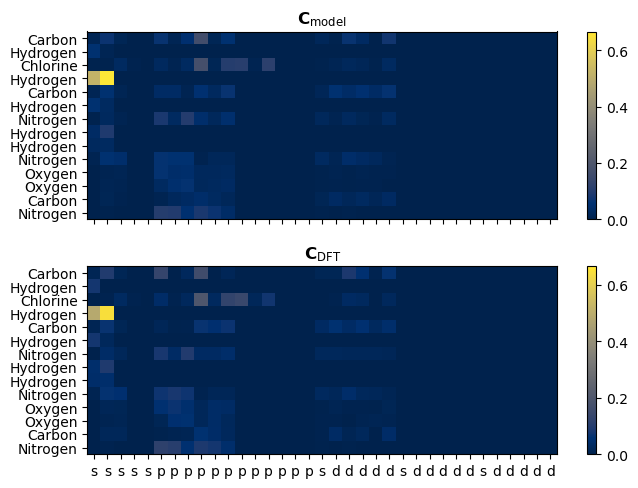

In [39]:
model = torch.load(os.path.join(artifact_dir_coeff, "reaction_model.pt"), map_location=torch.device('cpu'))

for idx, data in enumerate(validation_loader):
    output = model(data)
    output = output.detach().numpy()
    sum_squares_ouput = np.sum(output**2)
    print(f"Sum of squares of output: {sum_squares_ouput:.3f}")

    expected = data.x_transition_state.detach().numpy()
    expected = np.abs(expected)
    sum_squares_expected = np.sum(expected**2)
    print(f"Sum of squares of expected: {sum_squares_expected:.3f}")

    difference = output - expected
    difference = np.abs(difference)
    sum_differences = np.sum(np.abs(difference))
    sumsq_differences = np.sum(difference**2)
    print(f"Sum of differences: {sum_differences:.3f}")
    print(f"Sum of squares of differences: {sumsq_differences:.3f}")
    print(f"Max differences", np.max(np.abs(difference)))

    fig, axs = plt.subplots(2, 1, figsize=(7,5),  sharey=True, sharex=True, facecolor='w')
    cax = axs[0].imshow(output, cmap="cividis")
    fig.colorbar(cax, ax=axs[0])
    axs[0].set_title(r"$\mathbf{C}_{\mathrm{model}}$")
    cax = axs[1].imshow(expected, cmap="cividis")
    fig.colorbar(cax, ax=axs[1])
    cax.set_clim(axs[0].get_images()[0].get_clim())
    axs[1].set_title(r"$\mathbf{C}_{\mathrm{DFT}}$")
    # cax = axs[2].imshow(difference, cmap="Blues")
    # fig.colorbar(cax, ax=axs[2])
    # axs[2].set_title(r"$\left | \mathbf{C}_{\mathrm{model}} - \mathbf{C}_{\mathrm{DFT}} \right | $")

    tickvals = data.species.view(-1).detach().numpy().flatten()
    tickvals_species = [atomic_names[int(tickval)] for tickval in tickvals]
    axs[0].set_yticks(np.arange(len(tickvals)))
    axs[0].set_yticklabels(tickvals_species)
    axs[1].set_yticks(np.arange(len(tickvals)))
    axs[1].set_yticklabels(tickvals_species)
    # axs[2].set_yticks(np.arange(len(tickvals)))
    # axs[2].set_yticklabels(tickvals_species)
    axs[0].set_xticks(np.arange(35))
    # axs[0].set_xticks(np.arange(4))
    axs[0].set_xticklabels(5 *["s"] + 12*["p"] + 3*["s" , "d" , "d" , "d" , "d" , "d"])
    # axs[0].set_xticklabels(1*["s"] + 3*["p"])
    # axs[0].set_ylabel("Atom Number")
    # axs[1].set_ylabel("Atom Number")
    # axs[2].set_ylabel("Atom Number")
    fig.tight_layout()
    # Improve dpi
    fig.set_dpi(100)
    plt.show()

    break

0.02407230254108134


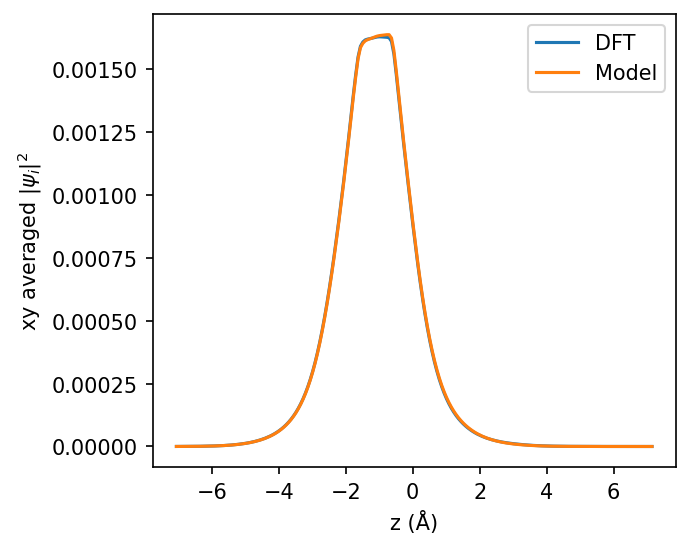

In [35]:
# Generate the sum of squares of the coefficient matrix
model = torch.load(os.path.join(artifact_dir_coeff, "reaction_model.pt"), map_location=torch.device('cpu'))

from ase.data import chemical_symbols
from pyscf import gto
from pyscf.dft.numint import eval_ao
from ase import Atoms
from ase.io.cube import write_cube

for idx, data in enumerate(validation_loader):

    basis_mask = data.basis_mask.detach().numpy()

    output = model(data)
    output = output.detach().numpy()
    output = output.flatten()[basis_mask.flatten()]

    expected = data.x_transition_state.detach().numpy()
    expected = expected.flatten()[basis_mask.flatten()]

    real_ts_coords = data.pos_transition_state.detach().numpy()
    interpolated_ts_coords = data.pos_interpolated_transition_state.detach().numpy()

    species = data.species.squeeze().detach().numpy()
    species_names = [chemical_symbols[int(species[i])] for i in range(len(species))]

    atoms_real_input = ""
    for i in range(len(species)):
        atoms_real_input += f"{species_names[i]} {real_ts_coords[i][0]} {real_ts_coords[i][1]} {real_ts_coords[i][2]}; "
    atoms_input = atoms_real_input[:-2]
    pyscf_mol = gto.M(atom=atoms_input, basis='6-31g*', charge=-1, cart=True)
    atoms = Atoms(symbols=species_names, positions=real_ts_coords)

    atoms_interpolated_input = ""
    for i in range(len(species)):
        atoms_interpolated_input += f"{species_names[i]} {interpolated_ts_coords[i][0]} {interpolated_ts_coords[i][1]} {interpolated_ts_coords[i][2]}; "
    atoms_input = atoms_interpolated_input[:-2]
    pyscf_mol_interpolated = gto.M(atom=atoms_input, basis='6-31g*', charge=-1, cart=True)
    interpolated_atoms = Atoms(symbols=species_names, positions=interpolated_ts_coords)

    x = np.linspace(np.min(real_ts_coords[:,0]) - 5, np.max(real_ts_coords[:,0]) + 5, 200)
    y = np.linspace(np.min(real_ts_coords[:,1]) - 5, np.max(real_ts_coords[:,1]) + 5, 200)
    z = np.linspace(np.min(real_ts_coords[:,2]) - 5, np.max(real_ts_coords[:,2]) + 5, 200)
    grid = np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3)

    atomic_orbital_grid = eval_ao(pyscf_mol, grid, deriv=0)
    predicted_orbital_grid = eval_ao(pyscf_mol_interpolated, grid, deriv=0) 

    sq_mo_diagonal = np.dot(atomic_orbital_grid**2, expected**2)
    predicted_sq_mo_diagonal = np.dot(predicted_orbital_grid**2, output**2)
    
    error_sq_mo_diagonal = np.abs(sq_mo_diagonal - predicted_sq_mo_diagonal)
    print(np.max(error_sq_mo_diagonal))

    # Average out the xy dimensions and plot both the real and predicted orbitals
    reshaped_sq_mo_diagonal = sq_mo_diagonal.reshape(len(x), len(y), len(z))
    reshaped_predicted_sq_mo_diagonal = predicted_sq_mo_diagonal.reshape(len(x), len(y), len(z))
    # Write out the cube files
    atoms.set_cell([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])
    interpolated_atoms.set_cell([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])
    # write_cube(open("output/real.cube", "w"), atoms, reshaped_sq_mo_diagonal, origin=(np.min(x), np.min(y), np.min(z)))
    # write_cube(open("output/predicted.cube", "w"), interpolated_atoms, reshaped_predicted_sq_mo_diagonal, origin=(np.min(x), np.min(y), np.min(z)))

    xy_averaged_sq_mo_diagonal = np.mean(reshaped_sq_mo_diagonal, axis=(0,1))
    xy_averaged_predicted_sq_mo_diagonal = np.mean(reshaped_predicted_sq_mo_diagonal, axis=(0,1))

    fig, axs = plt.subplots(1, 1, figsize=(4.5,4))
    axs.plot(z, xy_averaged_sq_mo_diagonal, label="DFT")
    axs.plot(z, xy_averaged_predicted_sq_mo_diagonal, label="Model")
    axs.set_xlabel("z (Å)")
    axs.set_ylabel(r"xy averaged $\left | \psi_i \right |^2$")
    axs.legend()
    fig.set_dpi(150)
    plt.show()
    

    break


In [37]:
# print(np.sum(sq_mo_diagonal))
# print(np.sum(predicted_sq_mo_diagonal))
print(x.shape)
print(y.shape)
print(z.shape)
print(reshaped_sq_mo_diagonal.shape)

print("Maximum of the sq_mo_diagonal", np.max(sq_mo_diagonal))
print("Maximum of the predicted_sq_mo_diagonal", np.max(predicted_sq_mo_diagonal))
print("Minimum of the sq_mo_diagonal", np.min(sq_mo_diagonal))
print("Minimum of the predicted_sq_mo_diagonal", np.min(predicted_sq_mo_diagonal))
mlab.figure(bgcolor=(1,1,1))
# mlab.pipeline.volume(mlab.pipeline.scalar_field(reshaped_sq_mo_diagonal), vmin=0, vmax=0.0001, )
# Plot the predicted orbitals in the same figure with another color
mlab.pipeline.volume(mlab.pipeline.scalar_field(reshaped_predicted_sq_mo_diagonal), vmin=0, vmax=0.0001, color=(1,0,0))
# Save the figure
# mlab.savefig("output/real.png")

(200,)
(200,)
(200,)
(200, 200, 200)
Maximum of the sq_mo_diagonal 0.09538090775527099
Maximum of the predicted_sq_mo_diagonal 0.09142486337409977
Minimum of the sq_mo_diagonal 1.1203891628520634e-18
Minimum of the predicted_sq_mo_diagonal 7.0673957036638325e-19


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [ ]:
# Read in the model
# model = torch.load("output/reaction_model.pt")
model = torch.load(os.path.join(artifact_dir_barrier, "reaction_model.pt"), map_location=torch.device('cpu'))

outputs = []
expecteds = []

for idx, data in enumerate(validation_loader):
    output = model(data)
    output = output.mean(dim=1)
    
    output = output.detach().numpy()
    expected = data.total_energy_transition_state - data.total_energy
    expected = expected.detach().numpy()

    outputs.append(output[0])
    expecteds.append(expected[0])


# Make a parity plot of the output vs. expected
outputs = np.array(outputs).flatten()
expecteds = np.array(expecteds).flatten()
outputs *= ase_units.Ha
expecteds *= ase_units.Ha

# Remove entries from output and expected that less than 0
# idx_to_remove = np.where(expecteds < 0)[0]
# outputs = np.delete(outputs, idx_to_remove)
# expecteds = np.delete(expecteds, idx_to_remove)


# Number of points
print(f"Number of points: {len(outputs)}")
# Determine the mean absolute error
mae = np.mean(np.abs(outputs - expecteds))
print(f"Mean absolute error: {mae:.3f} eV")

fig = px.scatter(x=expecteds, y=outputs, template="simple_white")
# fig.update_layout(title="Parity plot of the output vs. expected barriers")
fig.update_xaxes(title_text="DFT Computed Barrier (eV)")
fig.update_yaxes(title_text="Model Output Barrier (eV)")
# Set x and y axes to be greater than 0
# fig.update_xaxes(range=[0, outputs.max()])
# fig.update_yaxes(range=[0, outputs.max()])
# Draw the parity line
fig.add_shape(
    type="line",
    x0=outputs.min(),
    y0=outputs.min(),
    x1=outputs.max(),
    y1=outputs.max(),
    line=dict(
        color="Red",
        width=4,
        dash="dashdot",
    )
)
# Reduce the aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
)


fig.show()